# Examining Impact Rating Results for a Specific Match

Looking at map 1 (de_mirage) of the following series between Mousesports and Faze from May 2020:

**https://www.hltv.org/matches/2340866/mousesports-vs-faze-esl-one-road-to-rio-europe**

The VOD for this match can be viewed here: https://youtu.be/9X7KpyXN5P0

This particular game has be chosen because it highlights key features of the Impact Rating system - specifically round 5, where the CT side unexpectedly win a full-eco round.

**Note:** the Impact Rating values shown in this notebook may be slightly different to results generated from processing the same demo with the most recent prediction model.

In [1]:
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML

import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib.request
import numpy as np
import seaborn as sns
sns.set()

In [2]:
# ignore this code block - loading json results into the notebook
u = 'https://gist.githubusercontent.com/Phil-Holland/e88c7f56e627db63e830a37b44c4317b/raw/8aee505cf479faaf24ed0062e732912066e09271/mousesports-vs-faze-m1-mirage.dem.rating.json.4'
with urllib.request.urlopen(u) as url:
    data = json.loads(url.read().decode())

## Overall Results

Faze won this map, with a final score of **16-10**.

### Player Ratings According to HLTV

The final map scoreboard, and HLTV rating 2.0 value for each player is shown below:

![](https://i.imgur.com/pgKhiVW.png)

### Player Ratings According to CS:GO Impact Rating

The Average Impact Rating (AIR) for each player is shown below.

In [3]:
def display_player_results(name):
    for p in data['players']:
        if p['name'] == name:
            print('{:<15} {:.3f}%'.format(name + ':', p['overallRating']['averageRating'] * 100.0))
            
print('> Mousesports:')
display_player_results('frozen')
display_player_results('woxic')
display_player_results('chrisJ')
display_player_results('ropz')
display_player_results('karrigan')

print('\n> Faze')
display_player_results('coldzera')
display_player_results('broky')
display_player_results('NiKo')
display_player_results('olofmeister')
display_player_results('rain')

> Mousesports:
frozen:         14.941%
woxic:          0.054%
chrisJ:         -3.252%
ropz:           -6.264%
karrigan:       -2.735%

> Faze
coldzera:       4.640%
broky:          0.428%
NiKo:           1.437%
olofmeister:    -4.605%
rain:           -1.889%


As you can see, frozen gets a disproportionately high rating compared to the rest of his team. This suggests that the game was only remotely close because of frozen's actions. Meanwhile, Faze had three players (coldzera, broky and NiKo) whose impact all positively contributed to their team's success.

Let's also plot each player's changing AIR scores as the game progressed. This will be more erratic at the start of the game, until enough rounds are played to calculate a reliable average.

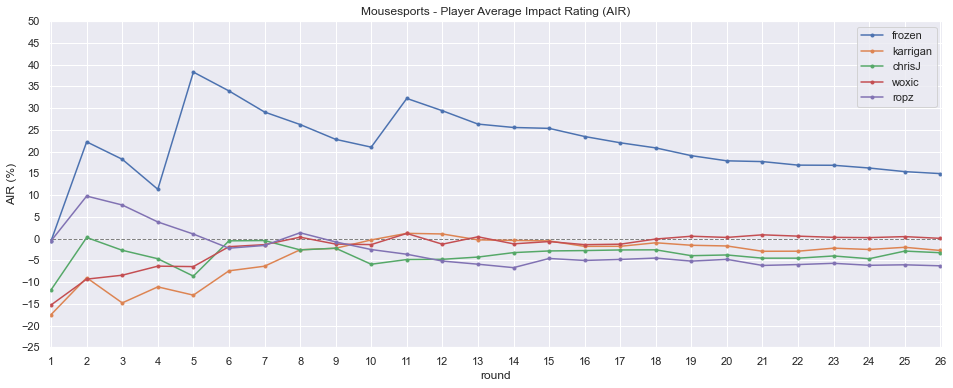

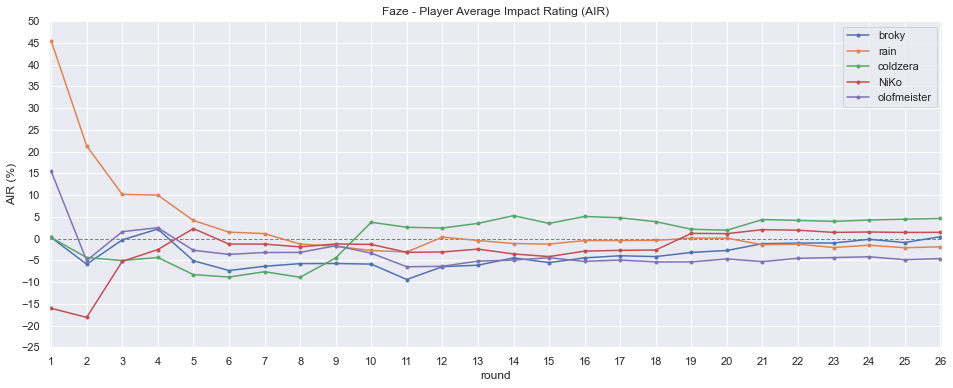

In [11]:
def plot_team(name, players):
    plt.figure(figsize=(16, 6))
    plt.axhline(0, -1000, 1000, c='grey', lw=1, linestyle='dashed')
    for p in data['players']:
        if p['name'] in players:
            rounds = [0]
            ratings = [0]
            for i, r in enumerate(p['roundRatings']):
                prev = ratings[-1] * rounds[-1]
                rounds.append(i+1)
                ratings.append((prev + r['totalRating'] * 100.0) / (i+1))
            plt.plot(rounds[1:], ratings[1:], label=p['name'], marker='.')
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(5))
    plt.xlim(0.95,26.05)
    plt.ylim(-25, 50)
    plt.legend()

    plt.title('{} - Player Average Impact Rating (AIR)'.format(name))
    plt.xlabel('round')
    plt.ylabel('AIR (%)')

    plt.show()
    
plot_team('Mousesports', ['frozen', 'woxic', 'chrisJ', 'ropz', 'karrigan'])
plot_team('Faze', ['coldzera', 'broky', 'NiKo', 'olofmeister', 'rain'])

The previous plot shows that coldzera started the map slowly, only achieving a positive average Impact Rating at round 10, but performs well from this point onwards, ending the map with a very strong average Impact Rating. Meanwhile, frozen quickly accumulates high Impact Rating values, keeping his average very high for the whole duration of the map.

## Individual Player Results

Let's break down frozen's performance to understand why they achieved this map's highest average Impact Rating.

### Round-By-Round Impact Rating

The following plot shows frozen's rating in each of the 26 rounds played.

**Note:** unlike the previous plot of **Average** Impact Ratings, this simply shows the frozen's rating in each individual round.

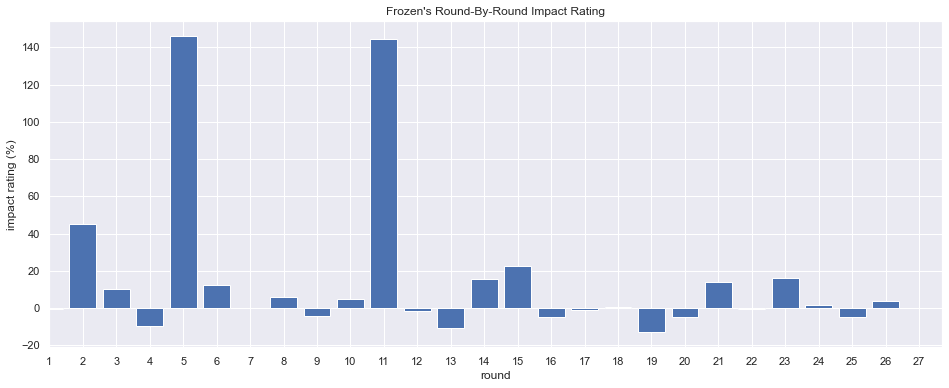

In [5]:
f_rounds = []
f_ratings = []
for p in data['players']:
    if p['name'] == 'frozen':
        for r in p['roundRatings']:
            f_rounds.append(r['round']['number'])
            f_ratings.append(r['totalRating'] * 100.0)

plt.figure(figsize=(16, 6))
plt.bar(f_rounds, f_ratings)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title('Frozen\'s Round-By-Round Impact Rating')
plt.xlabel('round')
plt.xlim(1,)
plt.ylabel('impact rating (%)')
plt.show()

This shows that frozen ended very few rounds with a substantial negative Impact Rating, and played a key role in two rounds specifically: **round 5** and **round 11**. These factors contribute to his high overall average Impact Rating.

### Single Round Breakdown

Let's look at **round 5** in detail, to see how frozen achieved such a high Impact Rating. The round in question can be viewed in the VOD below:

In [6]:
HTML('<center><iframe width="960" height="540" src="https://www.youtube.com/embed/9X7KpyXN5P0?start=674&end=815&version=3" frameborder="0" allowfullscreen></iframe></center>')

As shown in the VOD, Faze have "full-bought" into the round, whereas mousesports have chosen to "full-eco", purchasing only a single flashbang. Mousesports end up winning the round after trading favourably in mid early, before Faze respond with entry kills leaving coldzera in a 1v2. He kills the first and plants the bomb, before frozen wins the 1v1 and defuses to win the round.

Let's first plot the **round outcome prediction probabilities**, to get an idea of how the model evaluated the round as it progressed. Annotations have been added to the plot to show the events that caused each change in prediction. The y-axis in this plot represents the predicted probability of a T-side round win - the dashed green line shows the 50% mark.

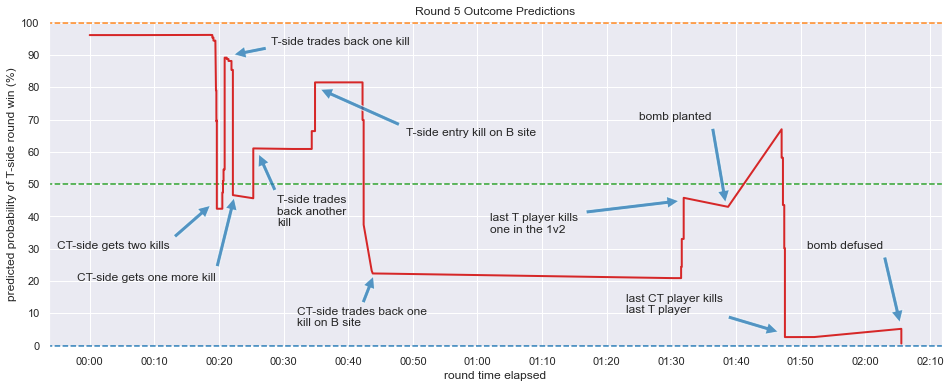

In [7]:
r_times = []
r_preds = []
round_start_tick = None

for rop in data['roundOutcomePredictions']:
    if rop['round']['number'] == 5:
        if round_start_tick == None:
            round_start_tick = rop['tick']
        r_times.append((rop['tick'] - round_start_tick) / 128)
        r_preds.append(rop['outcomePrediction'] * 100.0)

plt.figure(figsize=(16, 6))
plt.axhline(0, -1000, 1000, c='tab:blue', linestyle='dashed')
plt.axhline(50, -1000, 1000, c='tab:green', linestyle='dashed')
plt.axhline(100, -1000, 1000, c='tab:orange', linestyle='dashed')
plt.plot(r_times, r_preds, lw=2, c='tab:red')

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10))
formatter = ticker.FuncFormatter(lambda s, x: time.strftime('%M:%S', time.gmtime(s)))
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel('round time elapsed')
plt.ylabel('predicted probability of T-side round win (%)')
plt.ylim(-0.5, 100.5)

plt.title('Round 5 Outcome Predictions')

# hardcode some annotations in
arrowprops = {'facecolor': 'tab:blue', 'shrink': 0.05, 'alpha': 0.75}
plt.gca().annotate('CT-side gets two kills', xy=(19, 44), xytext=(-5, 30), arrowprops=arrowprops)
plt.gca().annotate('T-side trades back one kill', xy=(22, 90), xytext=(28, 93), arrowprops=arrowprops)
plt.gca().annotate('CT-side gets one more kill', xy=(22.5, 47), xytext=(-2, 20), arrowprops=arrowprops)
plt.gca().annotate('T-side trades\nback another\nkill', xy=(26, 60), xytext=(29, 37), arrowprops=arrowprops)
plt.gca().annotate('T-side entry kill on B site', xy=(35, 80), xytext=(49, 65), arrowprops=arrowprops)
plt.gca().annotate('CT-side trades back one\nkill on B site', xy=(44, 22), xytext=(32, 6), arrowprops=arrowprops)
plt.gca().annotate('last T player kills\none in the 1v2', xy=(92, 45), xytext=(62, 35), arrowprops=arrowprops)
plt.gca().annotate('bomb planted', xy=(98.5, 43), xytext=(85, 70), arrowprops=arrowprops)
plt.gca().annotate('last CT player kills\nlast T player', xy=(107, 4), xytext=(83, 10), arrowprops=arrowprops)
plt.gca().annotate('bomb defused', xy=(125.5, 6), xytext=(111, 30), arrowprops=arrowprops)

plt.show()

As you can see, the initial buys from both teams has led the model to initially predict a very likely T-side round win (~95% probability). As the round progresses, the prediction changes dramatically, and ends with a certain CT round win as the final kill is found and the bomb is defused.

Now let's look at how frozen's individual Impact Rating changes as the round develops.

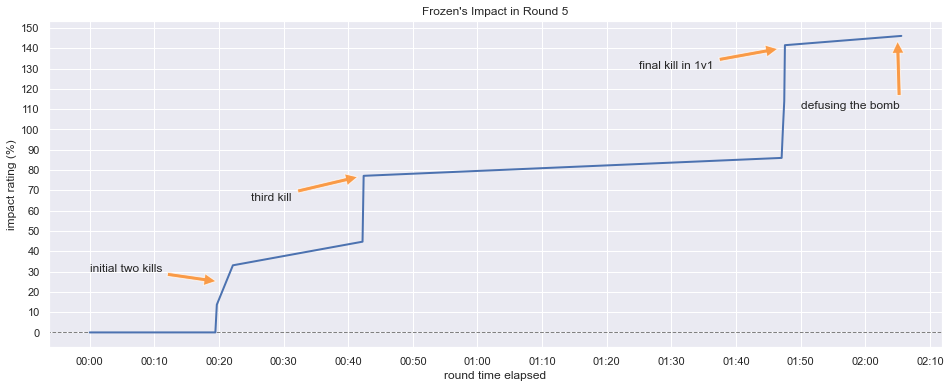

In [8]:
frozen_id = 76561198068422762
f_times = [0]
f_ratings = [0]
round_start_tick = None

for rop in data['roundOutcomePredictions']:
    if rop['round']['number'] == 5 and round_start_tick == None:
        round_start_tick = rop['tick']

for rc in data['ratingChanges']:
    if rc['round']['number'] == 5:
        if rc['player'] == frozen_id:
            f_times.append((rc['tick'] - round_start_tick) / 128)
            f_ratings.append(f_ratings[-1] + rc['change'] * 100.0)

plt.figure(figsize=(16, 6))
plt.axhline(0, -1000, 1000, c='grey', lw=1, linestyle='dashed')
plt.plot(f_times, f_ratings, lw=2)

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10))
formatter = ticker.FuncFormatter(lambda s, x: time.strftime('%M:%S', time.gmtime(s)))
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel('round time elapsed')
plt.ylabel('impact rating (%)')

plt.title('Frozen\'s Impact in Round 5')

# hardcode some annotations in
arrowprops = {'facecolor': 'tab:orange', 'shrink': 0.05, 'alpha': 0.75}
plt.gca().annotate('initial two kills', xy=(20, 25), xytext=(0, 30), arrowprops=arrowprops)
plt.gca().annotate('third kill', xy=(42, 77), xytext=(25, 65), arrowprops=arrowprops)
plt.gca().annotate('final kill in 1v1', xy=(107, 140), xytext=(85, 130), arrowprops=arrowprops)
plt.gca().annotate('defusing the bomb', xy=(125, 145), xytext=(110, 110), arrowprops=arrowprops)
plt.show()

As you can see, frozen was directly involved in multiple events during the round which swayed the round into his team's favour.

## Individual Round Results

As another example, let's look at **round 8**. The VOD for the round is shown below:

In [9]:
HTML('<center><iframe width="960" height="540" src="https://www.youtube.com/embed/9X7KpyXN5P0?start=1084&end=1135&version=3" frameborder="0" allowfullscreen></iframe></center>')

As you can see, the T side try an A site execute 20 seconds into the round, but fail to secure the bombsite as they get sandwiched by the CTs.

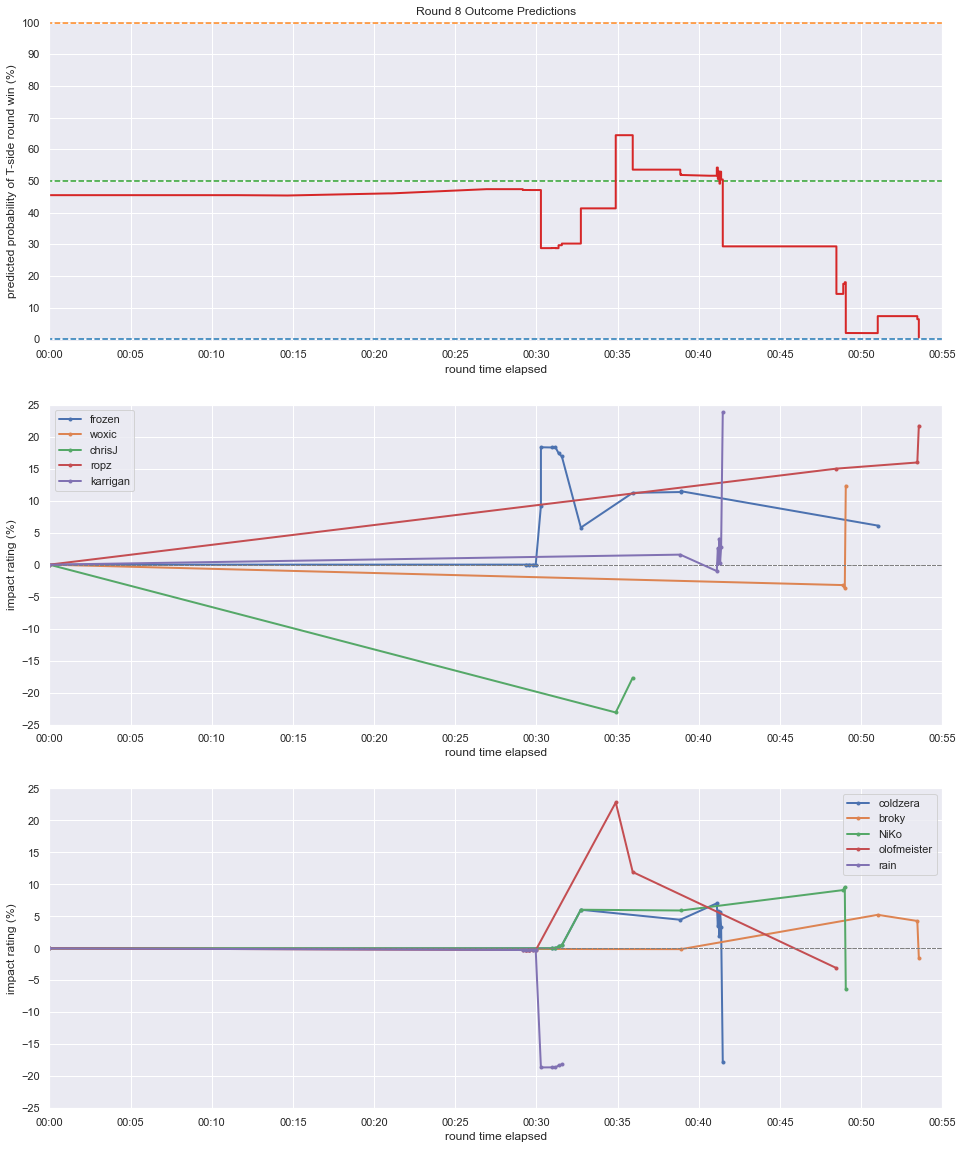

In [10]:
ROUND = 8

player_ids = {}
for p in data['players']:
    player_ids[p['name']] = p['steamID']

plt.figure(figsize=(16, 20))
ax1 = plt.subplot(3,1,1)

# show the round outcome predictions plot
r_times = []
r_preds = []
round_start_tick = None

for rop in data['roundOutcomePredictions']:
    if rop['round']['number'] == ROUND:
        if round_start_tick == None:
            round_start_tick = rop['tick']
        r_times.append((rop['tick'] - round_start_tick) / 128)
        r_preds.append(rop['outcomePrediction'] * 100.0)

plt.axhline(0, -1000, 1000, c='tab:blue', linestyle='dashed')
plt.axhline(50, -1000, 1000, c='tab:green', linestyle='dashed')
plt.axhline(100, -1000, 1000, c='tab:orange', linestyle='dashed')
plt.plot(r_times, r_preds, lw=2, c='tab:red')

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10))
formatter = ticker.FuncFormatter(lambda s, x: time.strftime('%M:%S', time.gmtime(s)))
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel('round time elapsed')
plt.ylabel('predicted probability of T-side round win (%)')
plt.ylim(-0.5, 100.5)

plt.title('Round {} Outcome Predictions'.format(ROUND))
    
def plot_player_round(name, i):
    ax2 = plt.subplot(3, 1, i, sharex=ax1)
    plt.xlabel('round time elapsed')
    plt.ylabel('impact rating (%)')
    plt.axhline(0, -1000, 1000, c='grey', lw=1, linestyle='dashed')

    p_times = [0]
    p_ratings = [0]       

    for rc in data['ratingChanges']:
        if rc['round']['number'] == ROUND:
            if rc['player'] == player_ids[name]:
                p_times.append((rc['tick'] - round_start_tick) / 128)
                p_ratings.append(p_ratings[-1] + rc['change'] * 100.0)
    plt.plot(p_times, p_ratings, lw=2, marker='.', label=name)
    
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(5))
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.ylim(-25, 25)
    plt.xlim(0, 55)
    plt.legend()

plot_player_round('frozen', 2)
plot_player_round('woxic', 2)
plot_player_round('chrisJ', 2)
plot_player_round('ropz', 2)
plot_player_round('karrigan', 2)

plot_player_round('coldzera', 3)
plot_player_round('broky', 3)
plot_player_round('NiKo', 3)
plot_player_round('olofmeister', 3)
plot_player_round('rain', 3)
    
plt.show()